# CM Credits research question 3

To what extent is it possible to find logical clusters of clients (eg. AMT_INCOME_TOTAL, DAYS_EMPLOYED, CNT_FAM_MEMBERS) and/or their loans (eg. AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE)?

To do this we will have to dive into the data and create an unsupervised machine learning model

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

## Data collection
Luckily the data for this project was already given

In [2]:
app_data = pd.read_csv("src/application_data.csv",sep=",", encoding='cp1252', index_col=0)
app_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Data understanding

Before we can create a model we will have to understand the data that is given, we have taken a look at all columns and found a couple that were interesting.

|Kolom naam|Omschrijving|Meetwaarde|
|-|-|-|
| AMT_CREDIT | Dit is de hoeveelheid dat de client als lening heeft gekregen. |Interval|
| AMT_GOODS_PRICE | Dit is de hoeveelheid dat wordt uitgeleend voor het product/investering van de client. |Interval|
| AMT_ANNUITY | Dit is hoeveel er maandelijks in termijnen terugbetaald moet worden door de klant. |Interval|
| AMT_INCOME_TOTAL | Het inkomen van de client wat er maandelijks wordt verdiend. |Interval|
| NAME_CONTRACT_TYPE | Geeft aan of het contract Cash is of Maandelijkse afschrift. |Nominaal|
| FLAG_OWN_REALTY | Geeft aan of een client een huis/flat bezit (In verband met minder/meer lenen). |Nominaal|
| FLAG_OWN_CAR | Geeft aan of iemand eigenaar is van een eigen auto. |Nominaal|
| CODE_GENDER | Geeft het gender aan van de client (interessant om te kijken of daar een verschil in zit). |Nominaal|
| DAYS_BIRTH | Hoeveel dagen de client is wanneer die op de dag van aanmelding. |Interval|
| NAME_EDUCATION_TYPE | Wat het hoogste behaalde schoolniveau is van de client. |Nominaal|

Lets take a look at the measurements we are working with

In [3]:
app_data.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


We can see that we have a lot of features to work with, lets see what the correlation is between some

### Data Cleaning / Transforming
Before we can do that, we will have to fit some data to be quantitative.

In [4]:
cols = ['NAME_EDUCATION_TYPE', 'CODE_GENDER', 
        'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 
        'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR']

# use sklearn's preprocessing labelencoder to transform the columns to corresponding ints
encoder = LabelEncoder()

# encode all columns
for col in cols:
    app_data[col] = encoder.fit_transform(app_data[col])

Let's also take a look at how many NaN values each column has.

In [5]:
# get the amount of NaN values per column
nan_count = app_data.isnull().sum()

for column in app_data:
    nan_count_for_column = nan_count[column]
    total_count = len(app_data)
    nan_percentage = (nan_count_for_column / total_count) * 100
    
    # print only the columns that actually have NaN values
    if nan_count_for_column > 0:
        print(f"For column: {column}, we have: {nan_count_for_column} nan values, which is {nan_percentage:.2f}% of the total.")

For column: AMT_ANNUITY, we have: 12 nan values, which is 0.00% of the total.
For column: AMT_GOODS_PRICE, we have: 278 nan values, which is 0.09% of the total.
For column: NAME_TYPE_SUITE, we have: 1292 nan values, which is 0.42% of the total.
For column: OWN_CAR_AGE, we have: 202929 nan values, which is 65.99% of the total.
For column: OCCUPATION_TYPE, we have: 96391 nan values, which is 31.35% of the total.
For column: CNT_FAM_MEMBERS, we have: 2 nan values, which is 0.00% of the total.
For column: EXT_SOURCE_1, we have: 173378 nan values, which is 56.38% of the total.
For column: EXT_SOURCE_2, we have: 660 nan values, which is 0.21% of the total.
For column: EXT_SOURCE_3, we have: 60965 nan values, which is 19.83% of the total.
For column: APARTMENTS_AVG, we have: 156061 nan values, which is 50.75% of the total.
For column: BASEMENTAREA_AVG, we have: 179943 nan values, which is 58.52% of the total.
For column: YEARS_BEGINEXPLUATATION_AVG, we have: 150007 nan values, which is 48.78%

Now we can look at the correlation

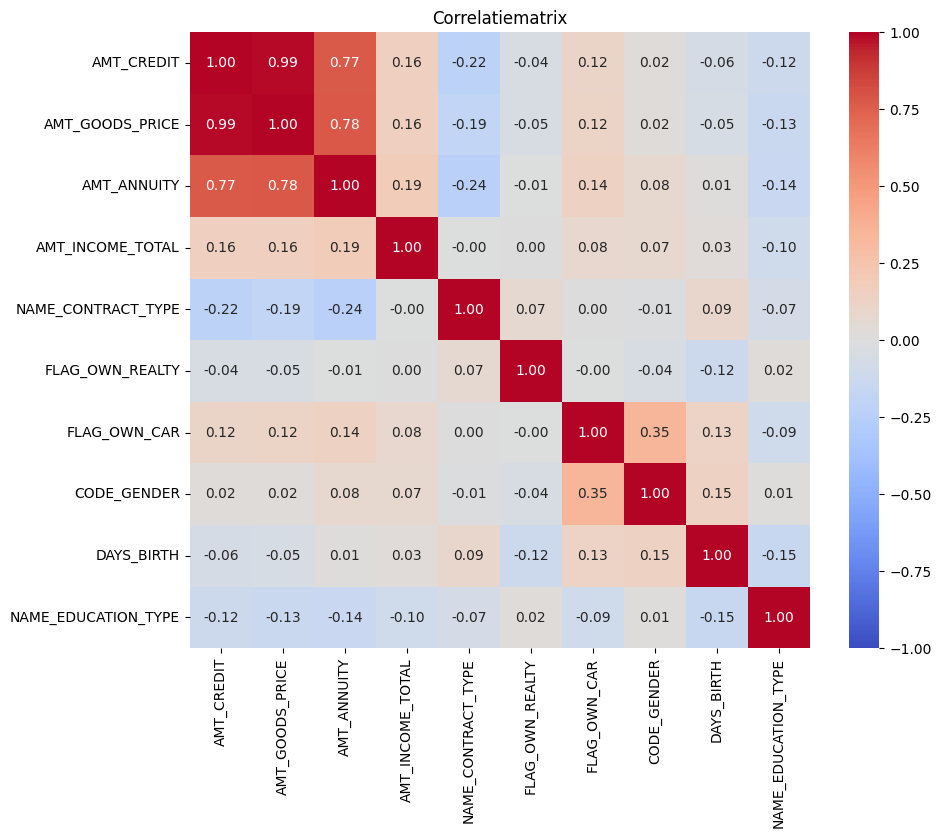

In [6]:
correlation_matrix = app_data[['AMT_CREDIT','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_INCOME_TOTAL','NAME_CONTRACT_TYPE','FLAG_OWN_REALTY','FLAG_OWN_CAR','CODE_GENDER','DAYS_BIRTH','NAME_EDUCATION_TYPE']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlatiematrix')
plt.show()

Let's see what the correlation looks like on the most correlating features

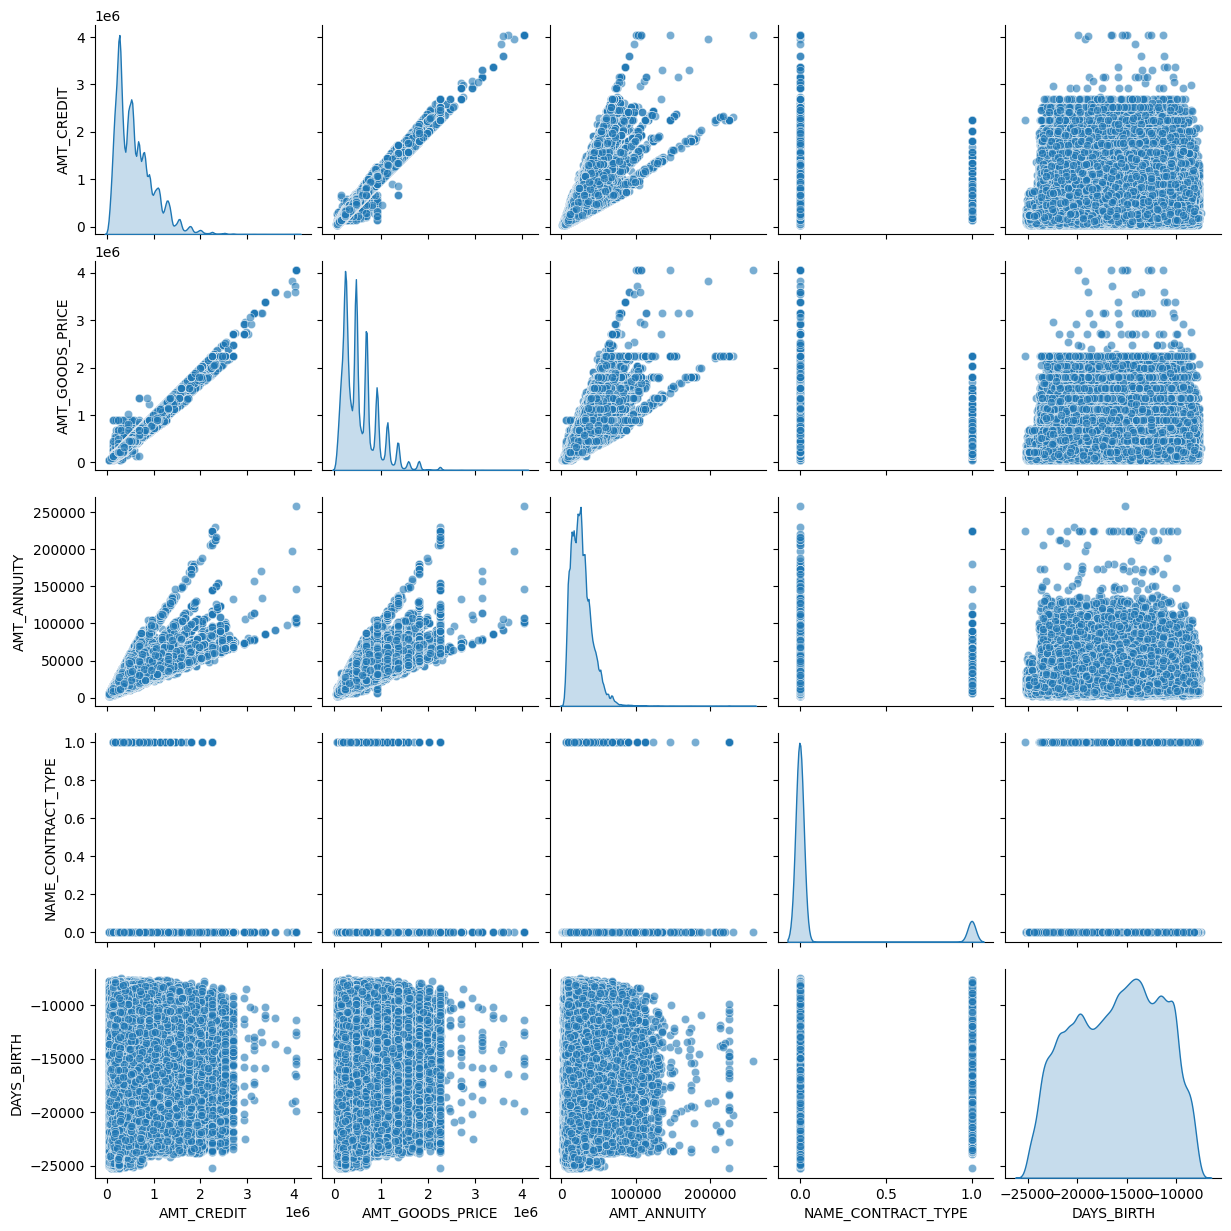

In [7]:
data_pairplot = app_data[['AMT_CREDIT','AMT_GOODS_PRICE','AMT_ANNUITY','NAME_CONTRACT_TYPE','DAYS_BIRTH']]

sns.pairplot(data_pairplot, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.show()

### Find outliers
Now we have a decent idea of what some good features might be, it is time to see whether or not these featerus have some weird values.

We will do this by creating some boxplots.

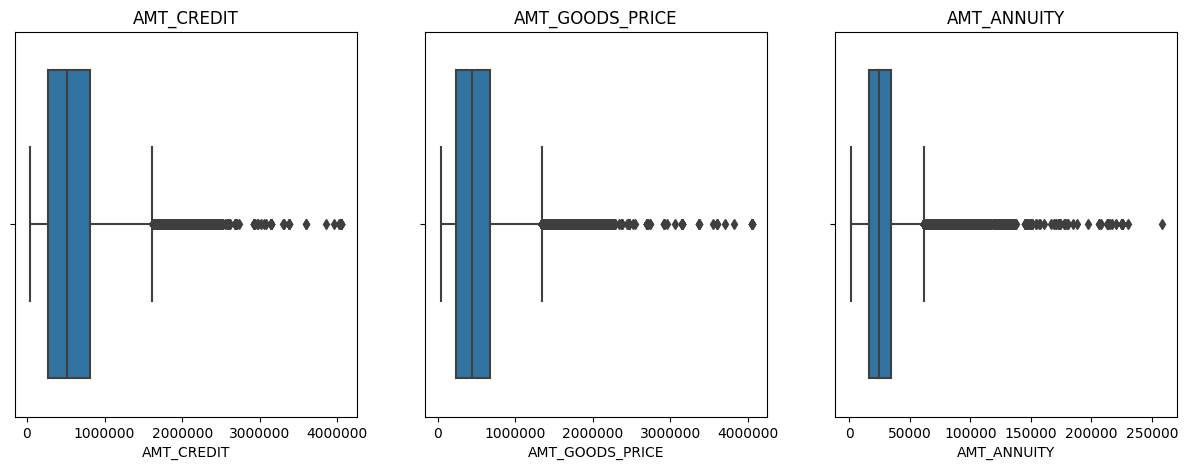

In [8]:
# Create a figure with 3 plots alongside eachother
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First boxplot
sns.boxplot(x=app_data['AMT_CREDIT'], ax=axes[0])
axes[0].set_title('AMT_CREDIT')
axes[0].get_xaxis().get_major_formatter().set_scientific(False)

# Second boxplot
sns.boxplot(x=app_data['AMT_GOODS_PRICE'], ax=axes[1])
axes[1].set_title('AMT_GOODS_PRICE')
axes[1].get_xaxis().get_major_formatter().set_scientific(False)

# Third boxplot
sns.boxplot(x=app_data['AMT_ANNUITY'], ax=axes[2])
axes[2].set_title('AMT_ANNUITY')
axes[2].get_xaxis().get_major_formatter().set_scientific(False)

plt.show()

### Histograms
Creating some histograms will help as well with detecting outliers

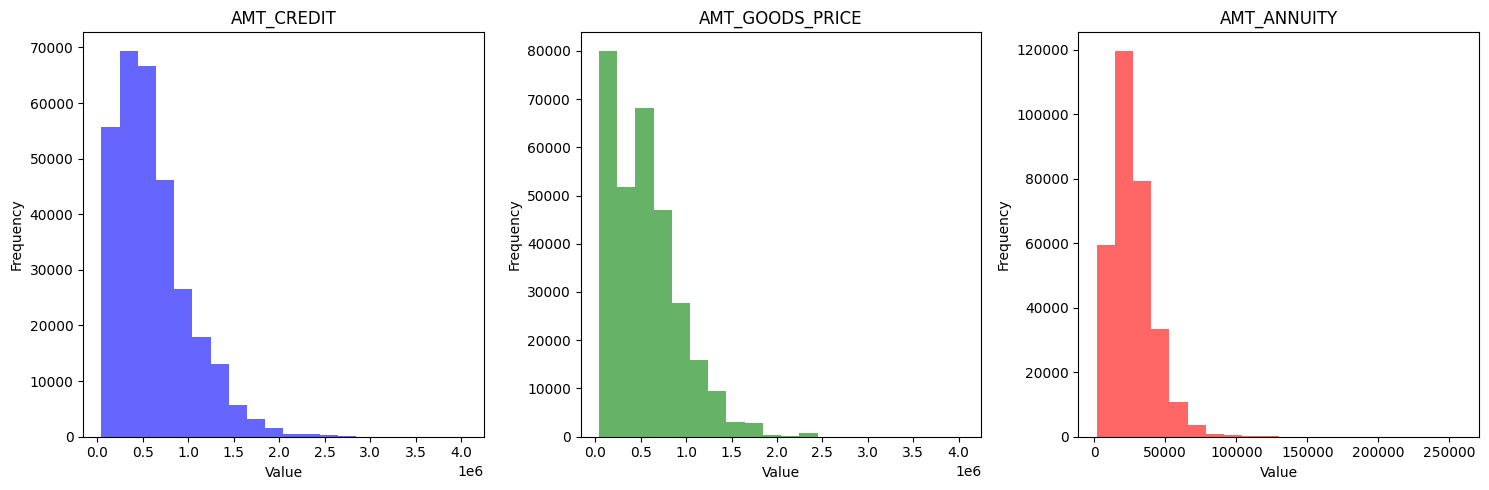

In [9]:
# Create a figure of three plots alongside eachother
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First histogram
axes[0].hist(app_data['AMT_CREDIT'], bins=20, color='blue', alpha=0.6)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('AMT_CREDIT')
axes[0].get_xaxis().get_major_formatter().set_scientific(True)

# Second histogram
axes[1].hist(app_data['AMT_GOODS_PRICE'], bins=20, color='green', alpha=0.6)
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('AMT_GOODS_PRICE')
axes[1].get_xaxis().get_major_formatter().set_scientific(True)

# Third histogram
axes[2].hist(app_data['AMT_ANNUITY'], bins=20, color='red', alpha=0.6)
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].set_title('AMT_ANNUITY')
axes[2].get_xaxis().get_major_formatter().set_scientific(True)

plt.tight_layout()
plt.show()

It comes immediately to our attentions that every feature has multiple outliers. A thick line is visible to the right of every whisker in the boxplots. The question is, are these true values? And do we want to keep them?

A good way to answer this is to take a look how many outliers there are compared to the total.

In [10]:
AMT_CREDIT = len(app_data[app_data['AMT_CREDIT'] > 1800000])

print(f"Amount of values above 1.8 milion: {AMT_CREDIT}")

AMT_GOODS_PRICE = len(app_data[app_data['AMT_GOODS_PRICE'] > 2000000])

print(f"Amount of values above 2 milion: {AMT_GOODS_PRICE}")

AMT_ANNUITY = len(app_data[app_data['AMT_ANNUITY'] > 80000])

print(f"Amount of values above 80 thousand: {AMT_ANNUITY}")

Total_Length_Data = len(app_data['AMT_CREDIT'])

print(f"Total amount of rows: {Total_Length_Data}")

Amount of values above 1.8 milion: 3279
Amount of values above 2 milion: 1093
Amount of values above 80 thousand: 1523
Total amount of rows: 307511


We could either remove the rows with outliers or replace the outliers with the median. In general it is beter to not remove data so we chose to do the latter. Later we found out it is best when we just keep the outliers as is.

We will be using KMeans and Gaussian Mixture, these models use distance so we will be normalizing our quantitative values using zscore.

In [11]:
# normalize the AMT_CREDIT and AMT_GOODS_PRICE using the zscore
columns = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
for col in columns:
    app_data[f'{col}_NORM'] = (app_data[col]-app_data[col].mean())/app_data[col].std()

# Modelling

We will create Kmeans models and Gaussian Mixture models and then see which is best

In [12]:
# Create the model objects
kmeans = KMeans()
gmm = GaussianMixture()

## Setup

In [13]:
# assign used values to X
X = app_data[['AMT_CREDIT_NORM', 'AMT_GOODS_PRICE_NORM']]

# Replace nan values to the median
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# setup possible params
param_grid = {
    'n_clusters': [n for n in range(1, 8)],  # You can adjust the range as needed
}

## Grid search

In [14]:
# create a grid search
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_clusters = best_params['n_clusters']
print(f"The best parameters found from the grid search were n_clusters = {best_n_clusters}")

  File "C:\Users\pepij\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


The best parameters found from the grid search were n_clusters = 7


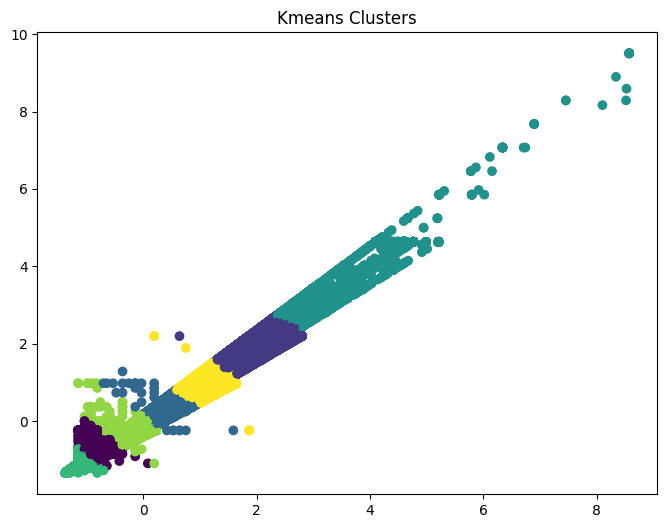

In [15]:
# Set hyper parameters
kmeans.set_params(n_clusters=best_n_clusters)

# Fit het model
kmeans.fit(X)

clusters = kmeans.predict(X)

# Scatterplot maken
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Kmeans Clusters')

plt.show()

Now lets do the same for GMM
## Setup

In [16]:
# with GGM it is possible to change the covariance
param_grid = {
    'n_components': [n for n in range(1, 8)],
    'covariance_type': ['full', 'tied']
}

## Grid search

In [17]:
# create a grid search
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_components = best_params['n_components']
best_covariance_type = best_params['covariance_type']
print(f"The best parameters found from the grid search were Ncomponents = {best_n_components} and covariance = {best_covariance_type}")

The best parameters found from the grid search were Ncomponents = 6 and covariance = full


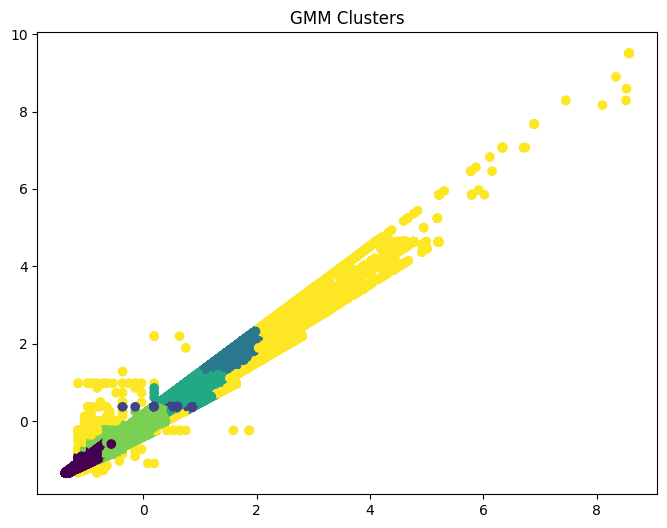

In [18]:
# Set hyper parameters and fit model
gmm.set_params(n_components=best_n_components, covariance_type=best_covariance_type, random_state=42)
gmm.fit(X)

# Get clusters
clusters = gmm.predict(X)

# create a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('GMM Clusters')
plt.show()

The other feature combination that could be interesting is AMT_ANNUITY and AMT_GOODS_PRICE, lets model them as well and then compare
## Setup

In [19]:
# assign used values to X
X = app_data[['AMT_ANNUITY_NORM','AMT_GOODS_PRICE_NORM']]

# replace NaNs with the mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# setup possible params
param_grid = {
    'n_clusters': [n for n in range(1, 8)],  # You can adjust the range as needed
}

## Grid search

In [20]:
# create a grid search
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_clusters = best_params['n_clusters']
print(f"The best parameters found from the grid search were n_clusters = {best_n_clusters}")

The best parameters found from the grid search were n_clusters = 7


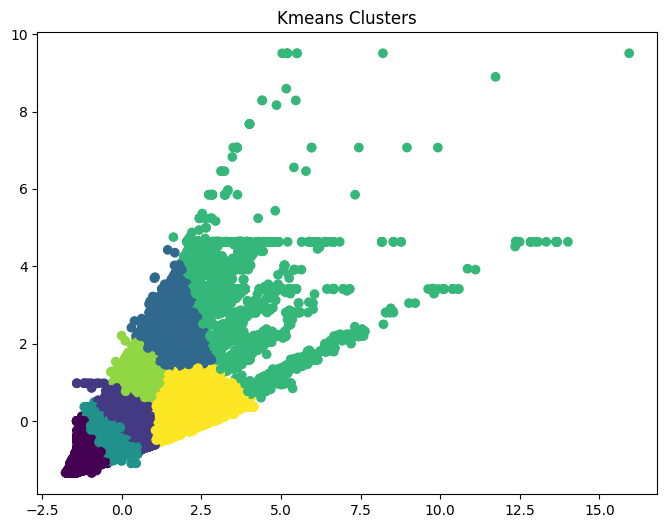

In [21]:
# Set hyper parameters and fit model
kmeans.set_params(n_clusters=best_n_clusters)
kmeans.fit(X)

# get clusters
clusters = kmeans.predict(X)

# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Kmeans Clusters')
plt.show()

Now do same for GMM
## Setup

In [22]:
param_grid = {
    'n_components': [n for n in range(1, 8)],  # Het aantal componenten (clusters) in het GMM-model
    'covariance_type': ['full', 'tied'],  # Het type covariantie
}

## Grid search

In [23]:
# create a grid search
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_components = best_params['n_components']
best_covariance_type = best_params['covariance_type']
print(f"The best parameters found from the grid search were Ncomponents = {best_n_components} and covariance = {best_covariance_type}")

The best parameters found from the grid search were Ncomponents = 7 and covariance = full


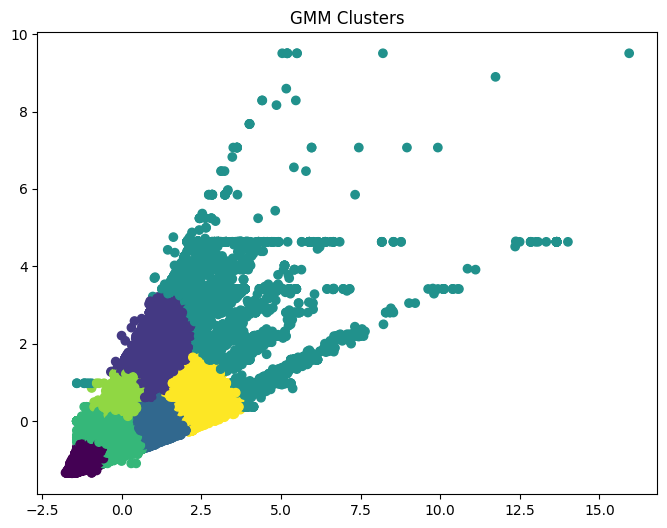

In [24]:
# Set hyper parameters and fit model
gmm.set_params(n_components=best_n_components, covariance_type=best_covariance_type, random_state=42)
gmm.fit(X)

# Get clusters
clusters = gmm.predict(X)

# create scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('GMM Clusters')
plt.show()

# Conclusion

To answer our research question: To what extent is it possible to find logical clusters of clients (eg. AMT_INCOME_TOTAL, DAYS_EMPLOYED, CNT_FAM_MEMBERS) and/or their loans (eg. AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE)? We already saw in the correlation diagrams that it would not be too easy to find clusters. We chose 2 pairs of features, (AMT_ANNUITY and AMT_GOODS_PRICE) and (AMT_GOODS_PRICE and AMT_CREDIT) to run on two models, Kmeans and Gaussian mixture. None of these resulted in a group of logical clusters that the bank could use. With that our answer concludes to, it is not possible to find logical clusters of clients and/or their loans. 